In [1]:
#the most important imports!
import numpy as np
import tensorflow as tf

#used for generating files for tensorboard
import sys
import urllib.request
import os

#used for visualizing
import matplotlib.pyplot as plt
#used to grab random samples to visualize
import random

In [2]:
if sys.version_info[0] >= 3:
    from urllib.request import urlretrieve
else:
    from urllib import urlretrieve

### create the log directory for tensorboard

In [3]:
LOGDIR = './tf_logs/mnist_deep' 

### weight and bias functions

In [4]:
def weight(shape):
    """Generates a weight variable of a given shape"""
    return tf.Variable(tf.truncated_normal(shape, stddev=.1), name="weight")

def bias(shape):
    """Generates a bias variable of a given shape"""
    return tf.Variable(tf.constant(.1, shape=shape), name="bias")
    

### get the dataset

In [5]:
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
X = tf.placeholder(tf.float32, [None, 784], name="X")
_y = tf.placeholder(tf.float32, [None, 10], name="labels")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


- there are 10000 images

In [6]:
len(mnist.test.images)

10000

- here we see that each image is stored as a single vector of length 784
- we will need to reshape that to (28,28) for visualization

In [7]:
mnist.test.images[0].shape

(784,)

In [8]:
#mnist.test.images[0]

### Lets take a look at a sample of the dataset
- rerun this block to look at different samples!

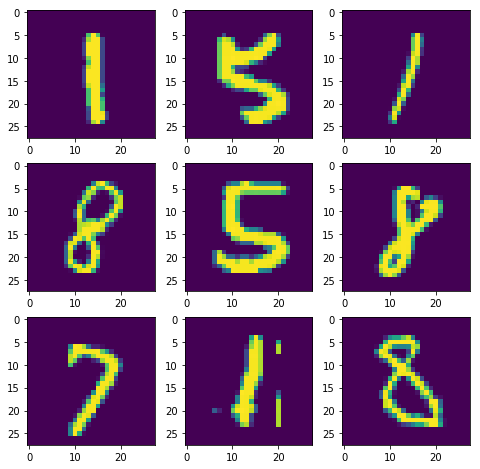

In [9]:
fig=plt.figure(figsize=(8,8)) #8"x8" figure
columns = 3
rows = 3
for i in range(1, 10):
    img = mnist.test.images[random.randint(0,10000)] #find some random images
    img = img.reshape((28,28)) #reshape the vector into a matrix
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## NN with softmax 

In [10]:
#drop in the code here, but not all in one block!

### Reshape the image to use with the CNN

In [11]:
with tf.name_scope("reshape"):
    x_image = tf.reshape(X, [-1, 28, 28, 1])
    tf.summary.image('input', x_image, 4)

### Convolution Layer
- maps a [28,28,1] grayscale image to [32] features
- **perhaps explain strides and padding**

In [12]:
with tf.name_scope('conv1'):
    Wc1 = weight([5,5,1,32])
    bc1 = bias([32])
    xc1 = tf.nn.conv2d(x_image, Wc1, strides=[1,1,1,1], padding="SAME")
    hc1 = tf.nn.relu(xc1 + bc1)
    tf.summary.histogram("weights", Wc1)
    tf.summary.histogram("biases", bc1)
    tf.summary.histogram("activations", hc1)

### Pooling Layer
- downsamples by 2x
- **perhaps explain reshaping**

In [13]:
with tf.name_scope('pool1'):
    hp1 = tf.nn.max_pool(hc1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    hp1_image = tf.reshape(hp1, [-1,14,14,1])
    tf.summary.image('conv1', hp1_image, 4)

### Second Convolution Layer
- maps [32] to [64]

In [14]:
with tf.name_scope('conv2'):
    Wc2 = weight([5,5,32,64])
    bc2 = bias([64])
    xc2 = tf.nn.conv2d(hp1, Wc2, strides=[1,1,1,1], padding="SAME")
    hc2 = tf.nn.relu(xc2 + bc2)
    tf.summary.histogram("weights", Wc2)
    tf.summary.histogram("biases", bc2)
    tf.summary.histogram("activations", hc2)

### Second Pooling Layer

In [15]:
with tf.name_scope('pool2'):
    hp2 = tf.nn.max_pool(hc2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    hp2_image = tf.reshape(hp2, [-1,7,7,1])
    tf.summary.image('conv2', hp2_image, 4)

- the original 28x28 image with 32 features is now 7x7 with 64 features

In [16]:
with tf.name_scope('fc1'):
    hpf = tf.reshape(hp2, [-1,7*7*64])
    Wfc1 = weight([7*7*64, 1024])
    bfc1 = bias([1024])
    hfc1 = tf.nn.relu(tf.matmul(hpf, Wfc1) + bfc1)
    tf.summary.histogram("weights", Wfc1)
    tf.summary.histogram("biases", bfc1)
    tf.summary.histogram("activations", hfc1)

### Dropouts
- prevents overfitting 

In [17]:
with tf.name_scope("dropout"):
    Pk = tf.placeholder(tf.float32)
    hfc1D = tf.nn.dropout(hfc1, Pk)

### Map features to labels

In [18]:
with tf.name_scope('fc-classify'):
    Wfc2 = weight([1024, 10])
    bfc2 = bias([10])
    y = tf.matmul(hfc1D, Wfc2) + bfc2

### define the loss

In [19]:
with tf.name_scope("loss"):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=_y, logits=y),
        name="cross_entropy")
    tf.summary.scalar('loss', cross_entropy)

### optimizer 

In [20]:
with tf.name_scope('optimizer'):
    train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy, name='train_step')


### define accuracy

In [21]:
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(_y,1))
    correct_prediction = tf.cast(correct_prediction, tf.float32, name='correct_prediction')
    accuracy = tf.reduce_mean(correct_prediction, name='accuracy')
    tf.summary.scalar('accuracy', accuracy)

### start session

In [22]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
merged = tf.summary.merge_all()

In [23]:
writer = tf.summary.FileWriter(LOGDIR, sess.graph)

### Set up embeddings for tensorboard visualization

In [24]:
GITHUB_URL ='https://raw.githubusercontent.com/mamcgrath/TensorBoard-TF-Dev-Summit-Tutorial/master/'
urlretrieve(GITHUB_URL + 'labels_1024.tsv', os.path.join(LOGDIR, 'labels_1024.tsv'))
urlretrieve(GITHUB_URL + 'sprite_1024.png', os.path.join(LOGDIR, 'sprite_1024.png'))
embedding = tf.Variable(tf.zeros([1024, 1024]), name="test_embedding")
assignment = embedding.assign(hfc1D)
saver = tf.train.Saver()

config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
embedding_config = config.embeddings.add()
embedding_config.tensor_name = embedding.name
embedding_config.sprite.image_path = 'sprite_1024.png'
embedding_config.metadata_path = 'labels_1024.tsv'
embedding_config.sprite.single_image_dim.extend([28, 28])
tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)

### train the network

In [25]:
# Do the training.
for i in range(1100):
    batch = mnist.train.next_batch(100)
    if i % 5 == 0:
        summary = sess.run(merged, feed_dict={X: batch[0], _y: batch[1], Pk: 1.0})
        writer.add_summary(summary, i)
    if i % 100 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={X:batch[0], _y: batch[1], Pk: 1.0})
        print("Step %d, Training Accuracy %g" % (i, float(train_accuracy)))
    if i % 500 == 0:
        sess.run(assignment, feed_dict={X: mnist.test.images[:1024], _y: mnist.test.labels[:1024], Pk: 1.0})
        saver.save(sess, os.path.join(LOGDIR, "model.ckpt"), i)
    sess.run(train_step, feed_dict={X: batch[0], _y: batch[1], Pk: 0.5})

Step 0, Training Accuracy 0.06
Step 100, Training Accuracy 0.85
Step 200, Training Accuracy 0.92
Step 300, Training Accuracy 0.93
Step 400, Training Accuracy 0.92
Step 500, Training Accuracy 0.98
Step 600, Training Accuracy 0.94
Step 700, Training Accuracy 0.99
Step 800, Training Accuracy 0.91
Step 900, Training Accuracy 0.94
Step 1000, Training Accuracy 0.99


### See how well the model performed

In [26]:
print("Test Accuracy %g" % sess.run(accuracy, feed_dict={X: mnist.test.images,
                                                         _y: mnist.test.labels,
                                                         Pk: 1.0}))

# Close summary writer
writer.close()

Test Accuracy 0.9697


this looks promising https://github.com/lspvic/jupyter_tensorboard (jupiter notebook hook for tensorboard)

timothy.s.darrah@vanderbilt.edu